In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os   
import os.path as osp

num_layers = 2
num_experts = 4

expert_path = '/home/yutang/Desktop/CLONE/visualization/moel_m1'
expert_files = [x for x in os.listdir(expert_path) if not x == 'walk.json']
expert_category = [x.replace('.json', '') for x in expert_files]
expert_files = [osp.join(expert_path, file) for file in expert_files if file.endswith('.json')]

expert_data = {}
for i, expert_file in enumerate(expert_files):
    with open(expert_file, 'r') as f:
        data = json.load(f)
        print('Processing: ', expert_category[i])

        keys_to_remove = []
        for key, value in data.items():
            v = dict(eval(value.replace('Counter(', '').replace(')', '')))
            new_v = []
            for j in range(num_experts):
                if j not in v:
                    new_v.append(0)
                    continue
                new_v.append(v[j])
            data[key] = new_v
        
        for key, value in data.items():
            if 'Expert 0' in key:
                nk = key.replace('Expert 0', 'Expert 1')
                nv = data[nk]
                for j in range(num_experts):
                    value[j] += nv[j]
                data[key] = value
            else:
                keys_to_remove.append(key)
                continue
            
        for key in keys_to_remove:
            del data[key]
        print(data)
        expert_data[expert_category[i]] = data

category_order = list(expert_data.keys())
category_order.sort()
category_order[0], category_order[1], category_order[2], category_order[3] = category_order[3], category_order[0], category_order[1], category_order[2]
category_order[2], category_order[-1] = category_order[-1], category_order[2]
category_order[5], category_order[-1] = category_order[-1], category_order[5]
category_order[-3], category_order[-2] = category_order[-2], category_order[-3]
category_order[5], category_order[4] = category_order[4], category_order[5]

activate_value = [[expert_data[c][key] for key in expert_data[c].keys()] for c in category_order]
activate_value = np.array(activate_value)
assert activate_value.shape[1] == num_layers
assert activate_value.shape[2] == num_experts

print(activate_value.shape)


Processing:  turn
{'Layer0 Expert 0': [33938, 13077, 30490, 16863], 'Layer1 Expert 0': [27139, 18925, 12328, 35976]}
Processing:  strightforward
{'Layer0 Expert 0': [1283, 624, 1261, 646], 'Layer1 Expert 0': [1135, 619, 533, 1527]}
Processing:  jump
{'Layer0 Expert 0': [1141, 664, 1031, 774], 'Layer1 Expert 0': [1163, 671, 425, 1351]}
Processing:  squat
{'Layer0 Expert 0': [3038, 560, 3433, 247], 'Layer1 Expert 0': [2402, 1110, 1380, 2386]}
Processing:  stepside
{'Layer0 Expert 0': [9567, 6696, 9401, 7222], 'Layer1 Expert 0': [9004, 5888, 4971, 13023]}
Processing:  still
{'Layer0 Expert 0': [10067, 10587, 10366, 10380], 'Layer1 Expert 0': [8806, 4799, 12875, 14920]}
Processing:  punch
{'Layer0 Expert 0': [4413, 3647, 6834, 4246], 'Layer1 Expert 0': [5661, 2768, 4698, 6013]}
Processing:  strightbackward
{'Layer0 Expert 0': [1332, 1043, 1292, 1089], 'Layer1 Expert 0': [1520, 785, 648, 1803]}
Processing:  crouchwalk
{'Layer0 Expert 0': [3177, 462, 3571, 68], 'Layer1 Expert 0': [2343, 1130

ValueError: Number of rows must be a positive integer, not 0

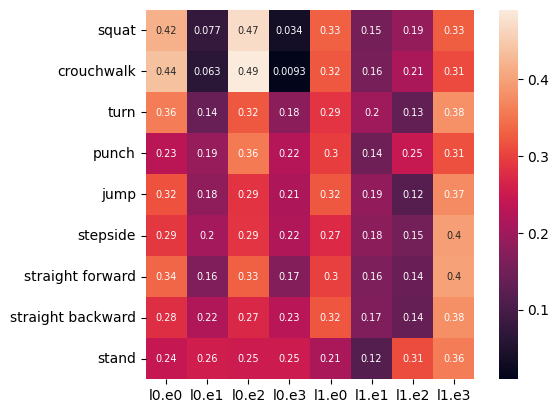

<Figure size 1500x0 with 0 Axes>

In [24]:
activate_value_norm = activate_value / (activate_value.sum(axis=2, keepdims=True) + 1e-8)
activate_value_norm = activate_value_norm.reshape(activate_value_norm.shape[0], -1)
rows = [x.replace('still', 'stand').replace('stright', 'straight ') for x in category_order]
cols = []
for l in range(num_layers):
    for e in range(num_experts):
        cols.append(f'l{l}.e{e}')

v_min = activate_value_norm.min()   
v_max = activate_value_norm.max()
df_norm_row = pd.DataFrame(activate_value_norm, index=rows, columns=cols)
# df_norm_row=df.divide(df.sum(axis=0), axis=1)
sns.heatmap(df_norm_row, annot=True, annot_kws={'size': 7}, square=True, cbar=True, vmin=v_min, vmax=v_max)

activate_value_norm = activate_value_norm.reshape(-1, num_layers, num_experts)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5 * ((num_layers + 2) // 2)))
for layer_idx in range(num_layers):
    plt.subplot(((num_layers + 2) // 2), 2, layer_idx + 1)
    
    # 获取当前层的激活值 (n x e)
    layer_data = activate_value_norm[:, layer_idx, :]
    
    # 创建热力图
    sns.heatmap(layer_data, 
                xticklabels=[f'E{i+1}' for i in range(num_experts)],
                yticklabels=rows if layer_idx == 0 else [],
                annot=True,
                annot_kws={'size': 7},
                square=True,
                cbar=False,
                fmt='.2f',
                vmin=v_min,
                vmax=v_max)
    
    plt.title(f'Layer {layer_idx + 1}')
    # plt.xlabel('Expert')
    if layer_idx == 0:
        plt.ylabel('Category')

plt.subplots_adjust(wspace=-0.6, hspace=0.2)
plt.savefig('activate_value_heatmap.pdf', dpi=600)
